## Imports

In [2]:
import pandas as pd 
import numpy as np
import re 
import geopandas
import folium
import matplotlib.pyplot as plt 
from collections import Counter
import datetime
from currency_converter import CurrencyConverter

In [3]:
company_df=pd.read_excel('dataset.xlsx',sheet_name='COMPANY')
investment_df=pd.read_excel('dataset.xlsx',sheet_name='INVESTMENT')
acquisition_df=pd.read_excel('dataset.xlsx',sheet_name='ACQUISITION')
employee_df=pd.read_excel('dataset.xlsx',sheet_name='EMPLOYEE')

## Quick view of the Dataframes

In [17]:
emp_number =company_df['EMPLOYEE_NUMBER'].unique().tolist()
emp_number


['1001-5000',
 '5001-10000',
 '51-100',
 '10001+',
 '1-10',
 '101-250',
 '501-1000',
 '251-500',
 '11-50',
 '—']

In [13]:
company_df.head(1)

,COMPANY_NAME,CATEGORY,LOCATION,FOUNDED_ON,EXITED_ON,CLOSED_ON,REVENU_RANGE,EMPLOYEE_NUMBER
0,Twitter,"Blogging Platforms, Messaging, SMS, Social Media","San Francisco, California, United States","Mar 21, 2006","Nov 7, 2013",—,$1B to $10B,1001-5000


In [4]:
investment_df.head(3)

,COMPANY_NAME,FUNDING_TYPE,MONEY_RAISED,ANNOUNCED_DATE,INVESTMENT_STAGE
0,Pipe,Venture - Series Unknown,"$250,000,000","Mar 31, 2021",—
1,Pipe,Series A,"$50,000,000","Mar 9, 2021",Early Stage Venture
2,Pipe,Seed,"$6,000,000","Feb 25, 2020",Seed


In [5]:
acquisition_df.head(3)

,COMPANY_NAME,ACQUIREE_NAME,ANNOUNCED_DATE,PRICE,ACQUISITION_TYPE
0,IBM,Turbonomic,"Apr 29, 2021","$2,000,000,000",Acquisition
1,IBM,myInvenio,"Apr 15, 2021",—,Acquisition
2,IBM,Taos Mountain,"Jan 14, 2021",—,Acquisition


In [6]:
employee_df.head(3)

,EMPLOYEE_MD5,JOB_TITLES,COMPANY_NAME,ATTENDED_SCHOOLS
0,aac4a9fe0edc50a77072eae64578a892,CEO,Twitter,NaN
1,f9c87bcba2ffe2237e039b2e2c86b16f,Co-Founder,Twitter,Northeastern University University of Massach...
2,36830ffebad9a630da8a7a03a45f2730,Team Member,Twitter,NaN


## 1) How many companies have received at least one round of investment?

In [7]:
len(investment_df['COMPANY_NAME'].unique())

935

## 2) On average, how much money each company has received at Series A round?

In [8]:
# First we need to convert to one-only currency (EUR)
def get_currency(string):
    res=None
    if string!='—' : # If the string is not null 
        pattern = r'[^\d,]+'
        res=re.findall(pattern, string)[0]

    return res

investment_df['RAW_CURRENCY']=investment_df['MONEY_RAISED'].apply(get_currency)
investment_df['RAW_CURRENCY'].unique()

array(['$', None, '€', '¥', '₹', '£', 'CA$', 'A$', 'CN¥', 'R$', 'ZAR',
       'SGD', '₩', 'CHF', 'MYR', 'SEK', 'RUB'], dtype=object)

In [9]:
# in order to convert the currencies into one same currency, let's use this package that works like this : 

c = CurrencyConverter()
c.convert(1, 'USD', 'EUR')

# To know which currencies in the dataframe should be renamed to work with this module, let's test each one with it : 
list_currencies =investment_df['RAW_CURRENCY'].unique().tolist()
mispelled_currencies =[]
for curr in list_currencies:

    try : 
        c.convert(1, 'USD', curr)
    except:
        mispelled_currencies.append(curr)

print(mispelled_currencies)
        

['$', None, '€', '¥', '₹', '£', 'CA$', 'A$', 'CN¥', 'R$', '₩', 'RUB']


In [10]:
# lets remap the mispelled currencies : 
remap={'$':'USD','€':'EUR','¥':'JPY','₹':'INR','£':'GBP','CA$':'CAD','A$':'AUD','CN¥':'CNY','₩':"KRW",'R$':'BRL'}
# we still miss RUB and R$ : for RUB (Russian Ruble) the package gives an error because we cannot convert it at the current datetime (war?) as we're gonna convert each transaction by precising the date the transaction was made, it not a problem
# we replace the mispelled currencies
investment_df.replace({"RAW_CURRENCY":remap},inplace=True)
# We convert the annouced date to datetime :
investment_df['ANNOUNCED_DATE']=pd.to_datetime(investment_df['ANNOUNCED_DATE'])
# We  only digits from the amounts in order to convert it to int 
investment_df['MONEY_RAISED']=investment_df['MONEY_RAISED'].apply(lambda x : int(re.sub(r'[^0-9]', '', x))if x!='—'else 0)
# We drop NA
investment_df=investment_df[(investment_df['MONEY_RAISED']>0) & (investment_df['RAW_CURRENCY']!=None)]
investment_df

,COMPANY_NAME,FUNDING_TYPE,MONEY_RAISED,ANNOUNCED_DATE,INVESTMENT_STAGE,RAW_CURRENCY
0,Pipe,Venture - Series Unknown,250000000,2021-03-31,—,USD
1,Pipe,Series A,50000000,2021-03-09,Early Stage Venture,USD
2,Pipe,Seed,6000000,2020-02-25,Seed,USD
3,Pipe,Seed,10000000,2020-06-24,Seed,USD
4,Epic Games,Seed,1000000000,2021-04-13,Seed,USD
...,...,...,...,...,...,...
5930,MDC Partners,Post-IPO Equity,95000000,2017-02-15,—,USD
5931,QueQ,Series A,2800000,2019-03-29,Early Stage Venture,USD
5932,PTC,Post-IPO Equity,1000000000,2018-06-11,—,USD
5933,Berkshire Hathaway,Post-IPO Equity,3510000,2019-08-15,—,USD


In [11]:
c = CurrencyConverter(fallback_on_wrong_date=True,fallback_on_missing_rate=True) # we activate the fallback on missing rate parameter which uses a linear interpolation when a currency is missed whitin the precised datetime
# We convert each value in money raised in euros, precising in which date the investment was made to get the right currency rate 
investment_df['MONEY_RAISED_IN_EUR']=investment_df.apply(lambda x : int(c.convert(x['MONEY_RAISED'],x['RAW_CURRENCY'],'EUR',date =x['ANNOUNCED_DATE'])),axis=1)

In [12]:
investment_df[investment_df['FUNDING_TYPE']=='Series A'].groupby('COMPANY_NAME')['MONEY_RAISED_IN_EUR'].mean()

COMPANY_NAME
1mg                     5595449.0
23andMe                 6307375.0
360VUZ                  6531307.0
ATAI Life Sciences     22081745.0
AbCellera Biologics     8541898.0
                          ...    
ipsy                    2261629.0
monday.com              6915377.0
project44               9353287.0
tabby                  18986296.0
ultimate.ai            16459550.0
Name: MONEY_RAISED_IN_EUR, Length: 535, dtype: float64

## 3) What are the distributions of the current status of these companies?

In [13]:
#convert ANNOUCED DATE in datetime
investment_df['ANNOUNCED_DATE']=pd.to_datetime(investment_df['ANNOUNCED_DATE'],errors='coerce')
#get the current status of each company (sort values by announced date and keep the most recent one)
current_status=investment_df[investment_df['INVESTMENT_STAGE']!='—'].sort_values('ANNOUNCED_DATE',ascending=False).groupby('COMPANY_NAME')['COMPANY_NAME','INVESTMENT_STAGE'].head(1)
# value counts of the curren status to get the distribution
current_status['INVESTMENT_STAGE'].value_counts()


<ipython-input-13-0f6c404011a2>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  current_status=investment_df[investment_df['INVESTMENT_STAGE']!='—'].sort_values('ANNOUNCED_DATE',ascending=False).groupby('COMPANY_NAME')['COMPANY_NAME','INVESTMENT_STAGE'].head(1)


Late Stage Venture     454
Early Stage Venture    237
Private Equity          61
Seed                    57
Name: INVESTMENT_STAGE, dtype: int64

## 4) Which company has the largest number of acquisitions?

In [14]:
# Filtering to have only acquistions, groupby company name and count, sort values and get the first value
acquisition_df[acquisition_df['ACQUISITION_TYPE']=='Acquisition'].groupby('COMPANY_NAME')['ACQUIREE_NAME'].count().sort_values(ascending=False).head(1)

COMPANY_NAME
Accenture    212
Name: ACQUIREE_NAME, dtype: int64

## 5) Which of these companies have CEOs graduated from a top school?

In [15]:
# Got a list of top schools and put in a regex format ( Harvard or MIT or Standford)
top_schools="Harvard|MIT|Stanford|Berkeley|Oxford|Washington|Columbia|Cambridge|Yale|ESCP"
graduated_CEO=employee_df[employee_df['JOB_TITLES']=='CEO'].dropna(subset=["ATTENDED_SCHOOLS"])
# combined with the str.contains, this line test if each ATTENDS SCHOOLS contain Harvard, or MIT or Standford...
graduated_CEO[graduated_CEO["ATTENDED_SCHOOLS"].str.contains(top_schools,case=False,regex=True)]['COMPANY_NAME']


107                   Google
2470                  Stripe
2608     Amazon Web Services
3625                 Netflix
4000               AngelList
4163                    Etsy
7158                  Ripple
12850              Indiegogo
14516              Metromile
14860                   Cleo
14902                Lattice
15461             OutSystems
15703           MercadoLibre
15745                   Lark
15883                 OneWeb
15909               Amperity
17338             Foursquare
17363                Beeswax
17504             Contentful
17655                 Tanium
18188                 Vonage
18344              Inscripta
18357            OpenLattice
19021                  Rover
20424                Corning
Name: COMPANY_NAME, dtype: object

In [16]:
graduated_CEO['TOP_SCHOOL']=graduated_CEO["ATTENDED_SCHOOLS"].str.contains(top_schools,case=False,regex=True)
graduated_CEO

,EMPLOYEE_MD5,JOB_TITLES,COMPANY_NAME,ATTENDED_SCHOOLS,TOP_SCHOOL
107,1695d67dedf7d6913b77025f96b43957,CEO,Google,Indian Institute of Technology Kharagpur Stan...,True
1879,5e78e4b5ec3d9b0690742153727f11f3,CEO,Apple,Duke University,False
2470,9345d3ea08ddf2688ee859ff8e630a14,CEO,Stripe,Massachusetts Institute of Technology - MIT,True
2608,adf442be572cadcd162976849cd0e4e9,CEO,Amazon Web Services,Harvard Business School Harvard University,True
3625,e6580847a7d4777abfb4e4ce17b5e2b1,CEO,Netflix,Bowdoin College Stanford University,True
...,...,...,...,...,...
20424,0126c5d5f6bc22b287b0dac867118da2,CEO,Corning,Harvard University Lehigh University,True
20451,f4230b5b27433167ab5d0261070d0a13,CEO,Plug Power,Temple University,False
20559,981ab6d5e43a0e0b873a26fae6144dc0,CEO,QueQ,King Mongkut's Institute of Technology Ladkra...,False
20560,8a04925d8044276c945aac347c708752,CEO,Exclaimer,University of Greenwich,False


##  6) Plot a map of the world, colored depending of the number of companies funded in it 

### 0) Pretreatment

In [17]:
# adding a columns with only the name, using the column LOCATION. the country is the last element seperated by commas, and there is a blank space at the beggining that we must delete.
company_df['COUNTRY']=company_df['LOCATION'].apply(lambda x : x.split(',')[-1][1:])

#### 1) Loading geopandas, a DataFrame with informations about all the countries

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


#### 2) Counting the number of companies founded in each country, and merging with the geoDataframe based on the column 'COUNTRY'

In [19]:
country_counts=pd.DataFrame(company_df['COUNTRY'].value_counts())
table=world.merge(country_counts,right_index=True,left_on=['name'])

#### 3) Looking at unmerged countries, correcting mispellings, and define unmatched countries 

In [20]:
print(country_counts[~country_counts.index.isin(table['name'])])
#Missing countries : Hong kong,Cayman Islands, Bahrain, Malta. I replaced singapore with Malaysia (not accurate but...) They are not present because they are small countries
country_counts.rename(index={'United States':'United States of America','Singapore':'Malaysia','The Netherlands':'Netherlands','Russian Federation':'Russia'},inplace=True)


                    COUNTRY
United States           660
Singapore                 6
The Netherlands           5
Russian Federation        4
Hong Kong                 3
Cayman Islands            2
Bahrain                   1
Malta                     1


#### 4 re-merge the geoDataframe and the counts of companies per country

In [21]:
table=world.merge(country_counts,right_index=True,left_on=['name'],how='left')
print(country_counts[~country_counts.index.isin(table['name'])])

                COUNTRY
Hong Kong             3
Cayman Islands        2
Bahrain               1
Malta                 1


#### 5) Creating a wolrd plot and saving it as html (map.html) please open it with a web browser 

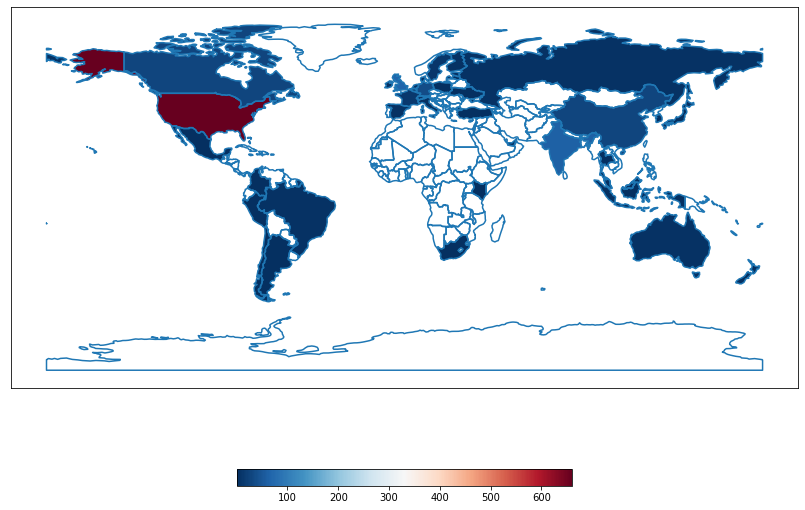

In [22]:
ax = table.boundary.plot(figsize=(20, 10))
table.plot(ax=ax, column='COUNTRY', legend=True,cmap='RdBu_r',legend_kwds={'shrink':0.3, 'orientation': 'horizontal'})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

6) ### The map is pretty inacurate : since the USA has 660 + companies, it is an outlier. I decided to remove this country from the plot in order to be more lisible

In [23]:
table.at[4,'COUNTRY']=0

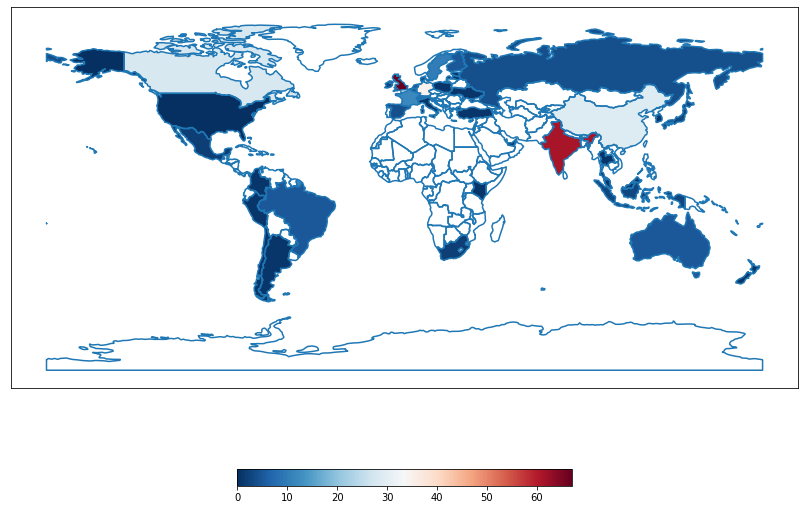

In [24]:
ax = table.boundary.plot(figsize=(20, 10))
table.plot(ax=ax, column='COUNTRY', legend=True,cmap='RdBu_r',legend_kwds={'shrink':0.3, 'orientation': 'horizontal'})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
## Script to save the plot as an HTML file 
my_map = folium.Map()
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'COUNTRY'],
    key_on='feature.properties.name',
    fill_opacity=0.7,
    line_opacity=0.2,
    threshold_scale=np.linspace(table['COUNTRY'].min(), table['COUNTRY'].max(), 6),
    legend_name='Number of Companies',
    color_continuous_scale="Viridis"
).add_to(my_map)
my_map.save('map.html')

### 7) From which countries does the top 50 companies with the most acquistion come from ? 

In [26]:
#Top 50 companies with the most Acqusition 
top_50_ac=acquisition_df[acquisition_df['ACQUISITION_TYPE']=='Acquisition']['COMPANY_NAME'].value_counts().head(50)
top_50_ac


Accenture                   212
Cisco                       196
Microsoft                   151
IBM                         125
Google                      114
Apple                        81
Oracle                       79
NortonLifeLock               64
Medtronic                    60
Siemens                      53
Intel                        53
Keywords Studios             52
Cognizant                    51
EQT                          51
SAP                          45
Qualcomm                     43
Merck                        43
Boston Scientific            42
Berkshire Hathaway           40
Schneider Electric           40
Apollo                       39
Roche                        39
Facebook                     36
Nokia                        34
RealPage                     33
Ericsson                     32
LabCorp                      31
Pfizer                       30
Alibaba Group                29
Delivery Hero                28
NCR                          28
Twitter 

In [27]:
# Get the countries of the top 50 from the company df, and get the distribution of the countries (the columns COUNTRY, added in 6) 0) is required)
company_df[company_df['COMPANY_NAME'].isin(top_50_ac.index)]['COUNTRY'].value_counts()

United States         32
Germany                3
France                 3
Switzerland            2
Sweden                 2
Ireland                2
Bahrain                1
China                  1
Russian Federation     1
India                  1
Finland                1
Canada                 1
Name: COUNTRY, dtype: int64

## 8) How many acquistion did the company with the most acquistions did per year ? (Accenture)

<AxesSubplot:title={'center':'Number of Acquisition per year for Accenture'}>

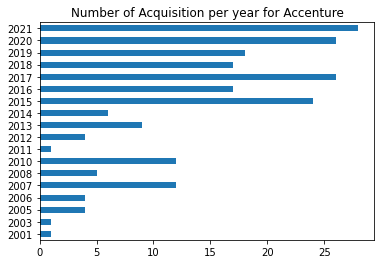

In [28]:
# Plot of the number of acquistion per year for the company with the most acquistions : Accenture
acquisition_df['ANNOUNCED_DATE']=pd.to_datetime(acquisition_df['ANNOUNCED_DATE'])
acquisition_df['ANNOUNCED_YEAR']=acquisition_df['ANNOUNCED_DATE'].apply(lambda x : x.year)
acquisition_df[acquisition_df['COMPANY_NAME']=='Accenture'].sort_values('ANNOUNCED_YEAR')['ANNOUNCED_YEAR'].value_counts(sort=False).plot(kind='barh',title='Number of Acquisition per year for Accenture')

<AxesSubplot:title={'center':'Number of Acquisition per year for Google'}>

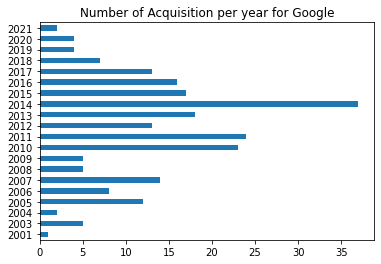

In [29]:
# Plot for other companies : 
company_name='Google'#try it with Google, Twitter
acquisition_df[acquisition_df['COMPANY_NAME']==company_name].sort_values('ANNOUNCED_YEAR')['ANNOUNCED_YEAR'].value_counts(sort=False).plot(kind='barh',title='Number of Acquisition per year for '+company_name)

## 9) What are the most represented industry categories in the Company Dataset ? (in % of companies)

In [30]:
# get a list of categories for each company 
categories=company_df['CATEGORY'].apply(lambda x : [cat.strip() for cat in x.split(',')]).to_list()
# flatten the list 
categories_flatten =[item for sublist in categories for item in sublist]
pd.Series(categories_flatten).value_counts()*100/len(company_df)
# 30,9% of the companies in the company DF are Software companies.

Software                                          30.9
FinTech                                           15.1
Financial Services                                15.0
SaaS                                              14.9
Information Technology                            14.5
                                                  ... 
Precious Metals                                    0.1
3D Printing                                        0.1
Commercial Insurance                               0.1
Social Entrepreneurship                            0.1
Application Specific Integrated Circuit (ASIC)     0.1
Length: 484, dtype: float64

## 10) Which companies had the shortest / longest Life span ? ( number of days between the day it was founded and the day it was exited)

In [31]:
# converter FOUNDED_ON and EXITED_ON into datetime
company_df['FOUNDED_ON']=pd.to_datetime(company_df['FOUNDED_ON'])
company_df['EXITED_ON']=pd.to_datetime(company_df['EXITED_ON'],errors='coerce')
# Create a sub df with only the exited companies
exited_companies=company_df.dropna(subset=['EXITED_ON'])
# Compute the lifespan (difference between EXITED and FOUNDED)
exited_companies['LIFESPAN']=exited_companies.apply(lambda x: x['EXITED_ON']- x['FOUNDED_ON'],axis=1)
# Companies with a negative lifespan must be error, let's delete them 
exited_companies=exited_companies[exited_companies['LIFESPAN']>datetime.timedelta(0)]


<ipython-input-31-a9b732033fb5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exited_companies['LIFESPAN']=exited_companies.apply(lambda x: x['EXITED_ON']- x['FOUNDED_ON'],axis=1)


In [32]:
# Shortest Lifespan
exited_companies.sort_values(by='LIFESPAN')[['COMPANY_NAME','LIFESPAN']].head(10)

,COMPANY_NAME,LIFESPAN
15,PhonePe,122 days
405,TerrAscend,123 days
458,Ideanomics,159 days
978,Xero,349 days
652,1mg,518 days
582,Instagram,551 days
60,Oculus,627 days
644,Lordstown Motors,664 days
11,Reddit,668 days
959,Clover,792 days


In [33]:
# Longest Lifespan
exited_companies.sort_values(by='LIFESPAN',ascending=False)[['COMPANY_NAME','LIFESPAN']].head(10)


,COMPANY_NAME,LIFESPAN
337,Sberbank,59276 days
811,Berkshire Hathaway,57473 days
106,Siemens,56329 days
520,Bayer,53388 days
507,Nokia,50918 days
34,Goldman Sachs,47614 days
830,Pfizer,47128 days
622,Corning,46398 days
876,NCR,41261 days
341,Allianz,40917 days


## 11) What's the most expensive acquisition ? 

In [34]:
# let's do the same treatment as with the investments

acquisition_df['RAW_CURRENCY']=acquisition_df['PRICE'].apply(get_currency)
acquisition_df['RAW_CURRENCY'].unique()
# lets remap the mispelled currencies : 
remap={'$':'USD','€':'EUR','¥':'JPY','₹':'INR','£':'GBP','CA$':'CAD','A$':'AUD','CN¥':'CNY','₩':"KRW",'R$':'BRL'}
# we still miss RUB  : for RUB (Russian Ruble) the package gives an error because we cannot convert it at the current datetime (war?) as we're gonna convert each transaction by precising the date the transaction was made, it not a problem
# we replace the mispelled currencies
acquisition_df.replace({"RAW_CURRENCY":remap},inplace=True)
# We convert the annouced date to datetime :
acquisition_df['ANNOUNCED_DATE']=pd.to_datetime(acquisition_df['ANNOUNCED_DATE'])
# We  only digits from the amounts in order to convert it to int 
acquisition_df['PRICE']=acquisition_df['PRICE'].apply(lambda x : int(re.sub(r'[^0-9]', '', x))if x!='—'else 0)
# We drop NA
acquisition_df=acquisition_df[(acquisition_df['PRICE']>0) & (acquisition_df['RAW_CURRENCY']!=None)]
c = CurrencyConverter(fallback_on_wrong_date=True,fallback_on_missing_rate=True) # we activate the fallback on missing rate parameter which uses a linear interpolation when a currency is missed whitin the precised datetime
# We convert each value in money raised in euros, precising in which date the acquisition was made to get the right currency rate 
acquisition_df['PRICE_IN_EUR']=acquisition_df.apply(lambda x : int(c.convert(x['PRICE'],x['RAW_CURRENCY'],'EUR',date =x['ANNOUNCED_DATE'])),axis=1)


In [35]:
acquisition_df

,COMPANY_NAME,ACQUIREE_NAME,ANNOUNCED_DATE,PRICE,ACQUISITION_TYPE,ANNOUNCED_YEAR,RAW_CURRENCY,PRICE_IN_EUR
0,IBM,Turbonomic,2021-04-29,2000000000,Acquisition,2021,USD,1648940555
10,IBM,CommQuest Services,1998-04-30,200000000,Acquisition,1998,USD,169649673
13,IBM,Micromuse,2005-12-21,865000000,Acquisition,2005,USD,728605121
19,IBM,Netezza,2010-09-20,1800000000,Acquisition,2010,USD,1376778338
36,IBM,Tivoli Systems,1996-02-01,743000000,Acquisition,1996,USD,630248536
...,...,...,...,...,...,...,...,...
5254,Pandora,Ticketfly,2015-10-06,450000000,Acquisition,2015,USD,400926585
5255,Pandora,AdsWizz,2018-03-22,145000000,Acquisition,2018,USD,117733030
5256,Axis Bank,FreeCharge,2017-07-27,60040000,Acquisition,2017,USD,51342568
5257,Sonos,Snips,2019-11-20,37500000,Acquisition,2019,USD,33909033


In [36]:
#List of acquisition from the most expensive to the least
sorted_deals= acquisition_df[(acquisition_df['ACQUISITION_TYPE']=='Acquisition') & (acquisition_df['PRICE']>0) ].dropna(subset=['PRICE']).sort_values(by='PRICE_IN_EUR',ascending=False)
sorted_deals


,COMPANY_NAME,ACQUIREE_NAME,ANNOUNCED_DATE,PRICE,ACQUISITION_TYPE,ANNOUNCED_YEAR,RAW_CURRENCY,PRICE_IN_EUR
1450,Pfizer,Warner-Lambert,2000-02-07,90000000000,Acquisition,2000,USD,92147025698
3701,The Walt Disney Company,21st Century Fox,2017-12-14,71300000000,Acquisition,2017,USD,60194174757
1464,Pfizer,Wyeth Nutritionals,2009-01-23,68000000000,Acquisition,2009,USD,53145760062
4855,Charter Communications,Spectrum,2015-05-26,56000000000,Acquisition,2015,USD,51253889804
4302,NVIDIA,Arm Holdings,2020-09-13,40000000000,Acquisition,2020,USD,33702185024
...,...,...,...,...,...,...,...,...
3525,Animoca Brands,Tribeflame,2018-02-07,433000,Acquisition,2018,USD,350948
1585,Keywords Studios,Syllabes,2019-12-17,475000,Acquisition,2019,CAD,323349
3519,Animoca Brands,Gamma Now,2019-06-27,350000,Acquisition,2019,USD,307827
1847,Sberbank,Rambler,2019-08-26,11000000,Acquisition,2019,RUB,150105


In [37]:
deal_no=0 # try with 0,1,2,3 ...

phrased="{0} has bought {1} for {2:,} {3} (€{4:,}) on {5}".format(sorted_deals.iloc[deal_no]['COMPANY_NAME'],sorted_deals.iloc[deal_no]['ACQUIREE_NAME'],sorted_deals.iloc[deal_no]['PRICE'],sorted_deals.iloc[deal_no]['RAW_CURRENCY'], sorted_deals.iloc[deal_no]['PRICE_IN_EUR'], sorted_deals.iloc[deal_no]['ANNOUNCED_DATE'].year)
print(phrased)

Pfizer has bought Warner-Lambert for 90,000,000,000 USD (€92,147,025,698) on 2000


## 12) What's the repartition of top schools whithin any specified company ? 

<ipython-input-38-d1fab4cfb4aa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company['TOP_SCHOOL']=company['ATTENDED_SCHOOLS'].apply(find_pattern)


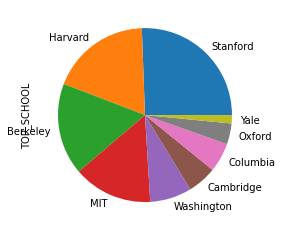

At Google, 129 out of the 1598 recorded employees graduated from a top school (8.07%)


In [38]:
company_name= 'Google' # try with 'Pfizer', 'Twitter', 'Facebook'

def find_pattern(string):
    res =None
    top_schools=r"Harvard|MIT|Stanford|Berkeley|Oxford|Washington|Columbia|Cambridge|Yale|ESCP"
    if not pd.isna(string) :
        match = re.search(top_schools, string)
        if match:
            res=match.group(0)
        
    return res


company=employee_df[employee_df['COMPANY_NAME']==company_name]
company['TOP_SCHOOL']=company['ATTENDED_SCHOOLS'].apply(find_pattern)
per_from_top_school=company['TOP_SCHOOL'].count()*100/len(company['TOP_SCHOOL'])
phraser="At {0}, {1} out of the {2} recorded employees graduated from a top school ({3:.2f}%)".format(company_name,company['TOP_SCHOOL'].count(),len(company['TOP_SCHOOL']),per_from_top_school)

company['TOP_SCHOOL'].value_counts().plot(kind='pie')
plt.show()
print(phraser)

## 13) What are the Alumnis of a specific school in the dataset ? 

In [39]:
school_name = 'ESCP' # try with Harvard, HEC, Seoul National University
alumnis=employee_df.dropna(subset=['ATTENDED_SCHOOLS'])
alumnis[alumnis['ATTENDED_SCHOOLS'].str.contains(school_name)]

,EMPLOYEE_MD5,JOB_TITLES,COMPANY_NAME,ATTENDED_SCHOOLS
48,bad2317579429087ce03440a496c539a,Head of Sales for the MENA,Twitter,ESCP Europe
5430,78126b73ec446d439566a39404727e14,Senior Consultant Adoption and Change Management,Microsoft,ESCP Europe
12015,632d1dc700758594338057f386fe949d,Head of Business Development EMEA,Chainalysis,ESCP Europe
14478,823aaaa5d1876d0a3a71852ed620c7f9,Executive Director of Business Development & P...,Babylon Health,ESCP Europe London Business School Panthéon-A...
15364,c25fde150286c72d30daa90763245b33,Vice President,Investcorp,ESCP Europe University of Genoa
